## MNIST CNN

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *

In [4]:
from fastai.basics import os

In [5]:
os.getcwd() #this is the path that I am now

'/home/jupyter/tutorials/fastai/course-v3/nbs/dl1'

### Data

MNIST is a dataset from fastai so I can call it with URLs. How can I see the availiable datasets in fastai? (https://course.fast.ai/datasets )

In [6]:
path = untar_data(URLs.MNIST) #change the path to where the MNIST dataset is

In [7]:
path

PosixPath('/home/jupyter/.fastai/data/mnist_png')

In [8]:
path.ls() #in my path, in mnist dataset there is a trainig and a testing dataset

[PosixPath('/home/jupyter/.fastai/data/mnist_png/models'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/testing')]

In [9]:
il = ImageList.from_folder(path, convert_mode='L')

In [10]:
il.items[0]

PosixPath('/home/jupyter/.fastai/data/mnist_png/training/9/39781.png')

In [11]:
defaults.cmap='binary'

In [32]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png

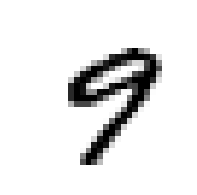

In [12]:
il[0].show()

In [13]:
sd = il.split_by_folder(train='training', valid='testing')

In [34]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [36]:
(path/'training').ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/3')]

In [14]:
ll = sd.label_from_folder()

In [40]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [15]:
x,y = ll.train[0]

9 torch.Size([1, 28, 28])


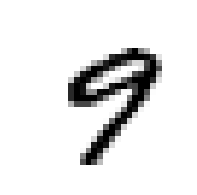

In [16]:
x.show()
print(y,x.shape)

In [17]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [18]:
ll = ll.transform(tfms)

In [19]:
bs = 128

In [48]:
bs

128

In [20]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [21]:
x,y = data.train_ds[0]

9


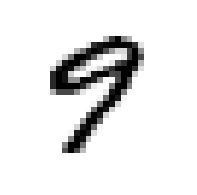

In [54]:
x.show()
print(y)

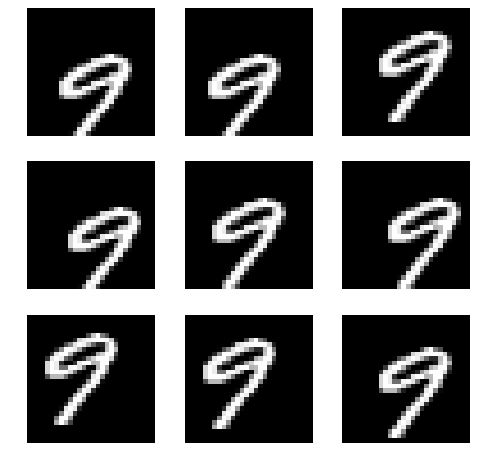

In [22]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray') #with gray cmap I have this outcome
#with 'binary' I have white fondo and black digits.
plot_multi(_plot, 3, 3, figsize=(8,8))

In [23]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

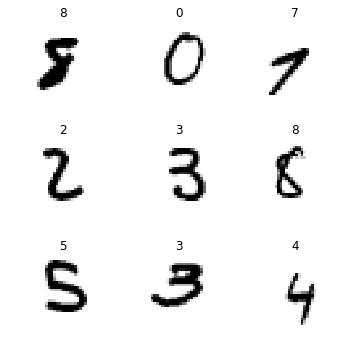

In [24]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [25]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [30]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [31]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [32]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

In [33]:
xb = xb.cuda()

In [34]:
model(xb).shape

torch.Size([128, 10])

In [35]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


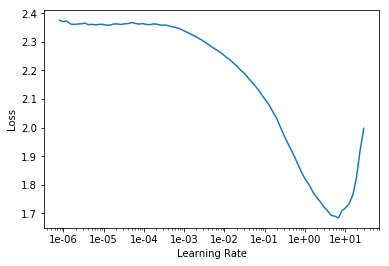

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.232411,0.144988,0.956200,00:51
1,0.140543,0.134221,0.957200,00:05
2,0.076965,0.043637,0.986200,00:05


### Refactor

In [38]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [41]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [42]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [43]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.250211,0.156974,0.950100,00:05
1,0.192594,0.118892,0.960200,00:05
2,0.169263,0.130904,0.961300,00:05
3,0.141255,0.086806,0.972200,00:05
4,0.121607,0.098161,0.970700,00:05
5,0.108172,0.063131,0.980600,00:05
6,0.080066,0.069777,0.978200,00:05
7,0.062264,0.037971,0.988300,00:05
8,0.049717,0.030939,0.990300,00:05
9,0.045198,0.028726,0.990500,00:05


### Resnet-ish

In [44]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [ ]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **kwargs)
    Resnet block of `nf` features.



In [45]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [46]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [47]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [48]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


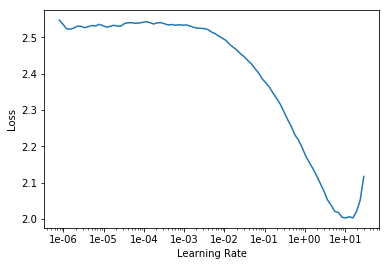

In [49]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.248807,0.121582,0.972800
2,0.120927,0.360583,0.890300
3,0.104013,0.074916,0.977800
4,0.081181,0.065717,0.980000
5,0.068514,0.096448,0.967200
6,0.061274,0.087955,0.971800
7,0.051673,0.033911,0.989400
8,0.048090,0.033234,0.988800
9,0.039095,0.024638,0.992400
10,0.023670,0.021215,0.993400


In [50]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________

## fin